<a href="https://colab.research.google.com/github/nikhil-1e9/Image-segmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up colab gpu runtime environment

In [20]:
!pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f8aa72fcc3f7d89c8c6d72c7e0d708a75f5d100eb842497f6cd61a3bc884eb73
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=16c5651f0bf88718399a6e41a2f1af4cb5cfb73ed5ba2478c79a6ef4b38d23cd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [1]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


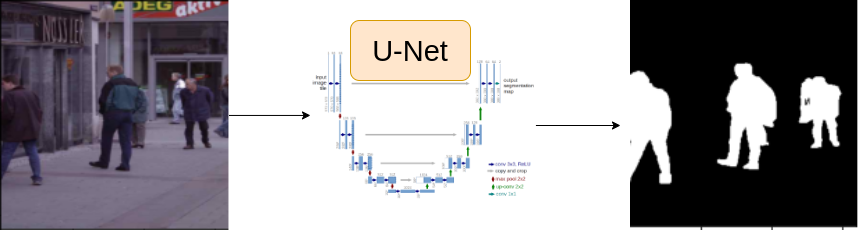

# Common Imports

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [5]:
# Define path variables
TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

# Define hyperparameters
EPOCHS = 20
LR = 0.001
IMG_SIZE = 320
BATCH_SIZE = 16

# Define pretrained model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

# Load Data

In [6]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


The dataframe consists of images and their corresponding masks. Let's see some of the sample images and masks.

# Explore the Data

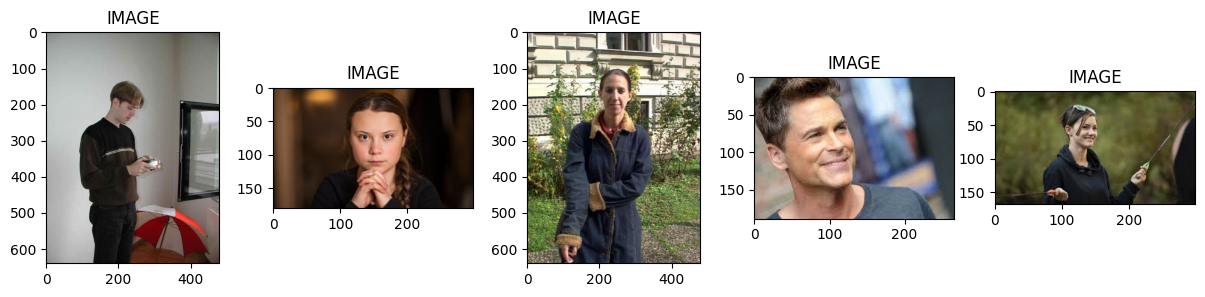

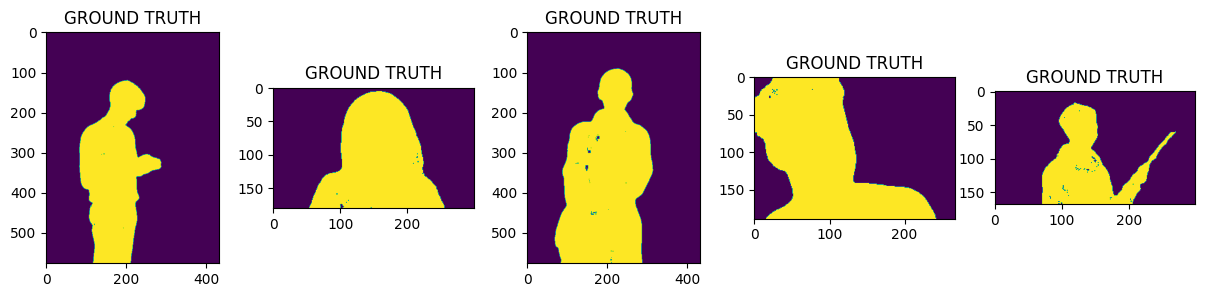

In [7]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask)

generate_sample_images(sample)
generate_sample_masks(sample)

# Split the Data

In [8]:
# Split data in separate train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

# Data Augmentation

I will be using the albumentation package for data augmentation part. For more information refer to the documentation : https://albumentations.ai/docs/

For classification tasks we apply augmentation techniques, such as rotating the image to some angle, cropping the image, increasing contrast, etc. to only the image as the labels are text values such as cat or dog. But in segmentation tasks we have to apply augmentation to both the image and the labels i.e. the image masks.

In [9]:
import albumentations as A

In [10]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

# Create Custom Dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")

        # (h,w,c) -> (c,h,w)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [13]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [14]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


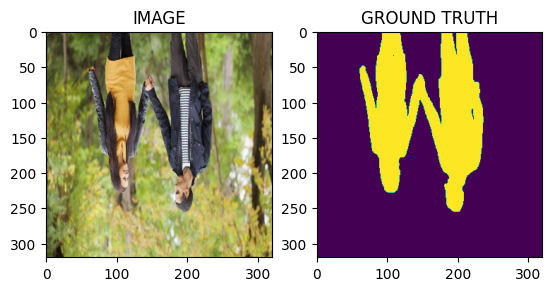

In [15]:
idx = 6
image, mask = train_data[idx]
plt.subplot(1,2,1)
plt.imshow(np.transpose(image, (1,2,0)))
plt.title("IMAGE");
plt.subplot(1,2,2)
plt.imshow(np.transpose(mask, (1,2,0)))
plt.title("GROUND TRUTH");
# helper.show_image(image, mask)

# Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

In [17]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 15
Total number of batches in Val Loader: 4


In [18]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([16, 3, 320, 320])
Size of one batch of masks: torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

There are many CNN models architectures present in the pytorch's segmentataion models documentation that can be used but for this project I will use Unet. Unet is a fully convolutional neural network for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation masks. It uses concatenation for fusing decoder blocks with skip connections.

In [21]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [50]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
            )

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [52]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
         

# Create Train and Validation Function

In [46]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [47]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

# Model Training

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [53]:
best_val_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")
        best_val_loss = val_loss

    print(f"Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


MODEL SAVED
Epoch 1 Train Loss 1.430410901705424 Val Loss 1.3648041784763336


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 2 Train Loss 1.4323091586430867 Val Loss 1.4003883004188538


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 3 Train Loss 1.4301880598068237 Val Loss 1.417156845331192


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 4 Train Loss 1.437002150217692 Val Loss 1.4277952909469604


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 5 Train Loss 1.427274966239929 Val Loss 1.4275182485580444


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch 6 Train Loss 1.4332159042358399 Val Loss 1.4237567484378815


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 7 Train Loss 1.4295961697896322 Val Loss 1.439127653837204


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch 8 Train Loss 1.428682597478231 Val Loss 1.4224188029766083


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 9 Train Loss 1.4287227074305215 Val Loss 1.4251799583435059


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 10 Train Loss 1.431128724416097 Val Loss 1.4267993569374084


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 11 Train Loss 1.4307933966318767 Val Loss 1.4344975650310516


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 12 Train Loss 1.4283809741338094 Val Loss 1.4265192151069641


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch 13 Train Loss 1.4315581639607748 Val Loss 1.420924961566925


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 14 Train Loss 1.4302485466003418 Val Loss 1.4264513850212097


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 15 Train Loss 1.4297400871912638 Val Loss 1.4301731884479523


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 16 Train Loss 1.4298108736673991 Val Loss 1.4334933161735535


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch 17 Train Loss 1.4269901116689045 Val Loss 1.4293148219585419


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 18 Train Loss 1.4325309197107952 Val Loss 1.429970920085907


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 19 Train Loss 1.4298650026321411 Val Loss 1.4279210567474365


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

Epoch 20 Train Loss 1.433209443092346 Val Loss 1.4327200949192047


# Inference

In [58]:
idx = 14
model.load_state_dict(torch.load("/content/best_model.pt"))
image, mask = val_data[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (1,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

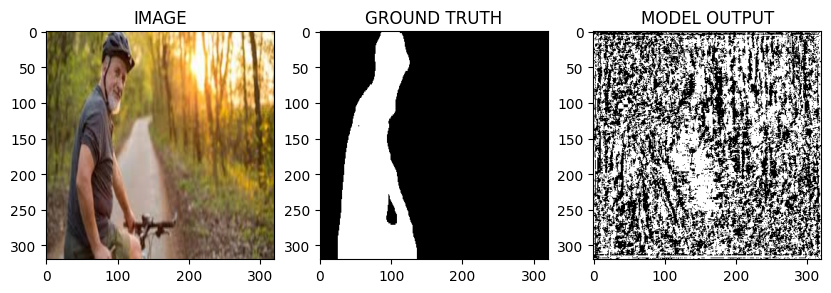

In [59]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# Summary